In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '0' = all logs, '3' = fatal errors only
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.feature_selection import mutual_info_classif
import shap
from sklearn.tree import DecisionTreeClassifier, plot_tree

shap.initjs()

# Downloading data

In [2]:
import kagglehub

path = kagglehub.dataset_download("crawford/gene-expression")

print("Path to dataset files:", path)

actual_df = pd.read_csv(path + "/actual.csv")
independent_df = pd.read_csv(path + "/data_set_ALL_AML_independent.csv")
train_df = pd.read_csv(path + "/data_set_ALL_AML_train.csv")

100%|██████████| 1.41M/1.41M [00:00<00:00, 24.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/crawford/gene-expression/versions/3


# Preprocessing

In [3]:
train_df

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,X83863_at,793,A,782,A,1138,A,627,A,...,279,A,737,A,588,A,1170,A,2315,A
7125,HMG2 High-mobility group (nonhistone chromosom...,Z17240_at,329,A,295,A,777,P,170,A,...,51,A,227,A,361,A,284,A,250,A
7126,RB1 Retinoblastoma 1 (including osteosarcoma),L49218_f_at,36,A,11,A,41,A,-50,A,...,6,A,-9,A,-26,A,39,A,-12,A
7127,GB DEF = Glycophorin Sta (type A) exons 3 and ...,M71243_f_at,191,A,76,A,228,A,126,A,...,2484,P,371,A,133,A,298,A,790,P


In [4]:
actual_df = actual_df.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML']

/tmp/ipython-input-4049934003.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  actual_df = actual_df.replace({'ALL':0,'AML':1})


In [5]:
actual_df

,patient,cancer
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
67,68,0
68,69,0
69,70,0
70,71,0


In [6]:
train_to_keep = [col for col in train_df.columns if "call" not in col]
test_to_keep = [col for col in independent_df.columns if "call" not in col]

X_train_tr = train_df[train_to_keep]
X_test_tr = independent_df[test_to_keep]

train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']


In [7]:
X_train_tr = X_train_tr.reindex(columns=train_columns_titles)
X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

X_train = X_train_tr.T
X_test = X_test_tr.T

X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)



In [8]:
from sklearn.model_selection import train_test_split


X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# 1) Combine all samples
X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# 2) Build full label vector (1 label per patient)
label_col = "cancer"
y_all = (
    actual_df.sort_values("patient")[label_col]
    .reset_index(drop=True)
)

# 3) 80:20 split
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)



In [9]:
X_train = X_train_80
y_train = y_train_80
X_test = X_test_20
y_test = y_test_20

PCA, normalization

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt


In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


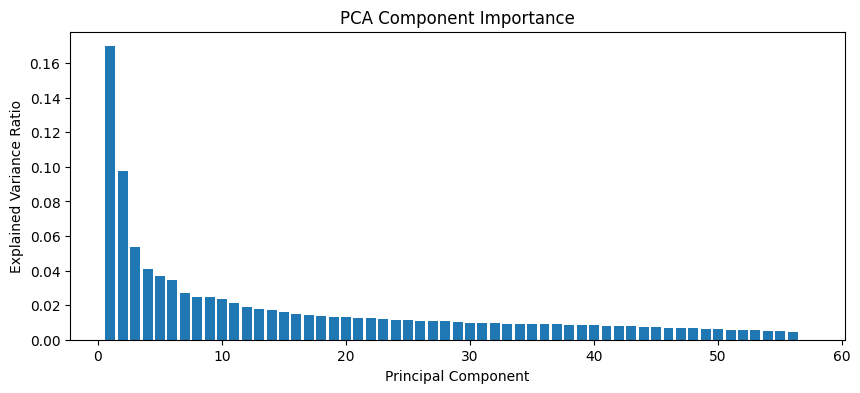

In [12]:
pca = PCA()
pca.fit(X_train_scaled)

# Transform the data
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot PCA importance
plt.figure(figsize=(10,4))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1),
        pca.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Component Importance")
plt.show()

# PCA feature importance = loading scores
pca_importance = np.abs(pca.components_[0])


In [13]:

f_scores, p_values = f_classif(X_train_scaled, y_train)

anova_ranking = pd.Series(f_scores, index=X_train.columns)
anova_ranking = anova_ranking.sort_values(ascending=False)


In [14]:
print(y_train.shape)
print(y_test.shape)

(57,)
(15,)


In [15]:
corr = pd.Series([
    np.abs(np.corrcoef(X_train_scaled[:, i], y_train.squeeze())[0, 1])
    for i in range(X_train.shape[1])
], index=X_train.columns)

corr_ranking = corr.sort_values(ascending=False)


# Selecting number of features

In [24]:
combined_rank = (
    anova_ranking.rank(ascending=False) +
    corr_ranking.rank(ascending=False) +
    pd.Series(pca_importance, index=X_train.columns).rank(ascending=False)
)

top_features = combined_rank.sort_values().index
print("Selected Top Features:", list(top_features))


Selected Top Features: ['U41767_s_at', 'X80907_at', 'HG3254-HT3431_at', 'U41635_at', 'D29963_at', 'U06681_at', 'U14588_at', 'HG2379-HT3996_s_at', 'M13485_at', 'M64108_at', 'M24900_at', 'D21261_at', 'U73514_at', 'D49677_at', 'X87838_at', 'AC000064_cds1_at', 'M55150_at', 'U10868_at', 'U67963_at', 'L38608_at', 'M26683_at', 'X16665_at', 'X62573_at', 'M98539_at', 'M29932_s_at', 'AJ000480_at', 'X70040_at', 'U47931_at', 'M93283_at', 'X85785_rna1_at', 'U52112_rna5_at', 'X15573_at', 'M93650_at', 'Z19554_s_at', 'U94836_at', 'HG4020-HT4290_s_at', 'L36069_at', 'U50136_rna1_at', 'U77604_at', 'S82470_at', 'X59892_at', 'L12392_at', 'X90846_s_at', 'U05681_s_at', 'Z48501_s_at', 'X83378_at', 'X83705_s_at', 'D31846_at', 'U14417_at', 'M81695_s_at', 'V01510_rna1_at', 'X58431_rna2_s_at', 'M32304_s_at', 'HG4535-HT4940_s_at', 'D43682_s_at', 'S79854_at', 'M80899_at', 'U27831_at', 'Y10376_at', 'J02888_at', 'U48936_at', 'U70867_at', 'U21689_at', 'S75213_s_at', 'L14856_at', 'L03785_at', 'M97016_s_at', 'J03474_at'

In [25]:
X_train_40 = X_train_scaled[:, [X_train.columns.get_loc(c) for c in top_features]]
X_test_40 = X_test_scaled[:, [X_test.columns.get_loc(c) for c in top_features]]


In [26]:
import pandas as pd

X_train_40 = X_train_scaled[:, [X_train.columns.get_loc(c) for c in top_features]]
X_test_40 = X_test_scaled[:, [X_test.columns.get_loc(c) for c in top_features]]

X_train_40_df = pd.DataFrame(X_train_40, columns=top_features)
X_test_40_df = pd.DataFrame(X_test_40, columns=top_features)


#Final dataframes to use for the Model:
1. Training data frame: X_train_40_df, y_train
2. Testing data frame: X_test_40_df, y_test

In [27]:
X_train_40_df.to_csv("X_train_all.csv", index=False)
X_test_40_df.to_csv("X_test_all.csv", index=False)
y_train.to_csv("y_train_all.csv", index=False)
y_test.to_csv("y_test_all.csv", index=False)


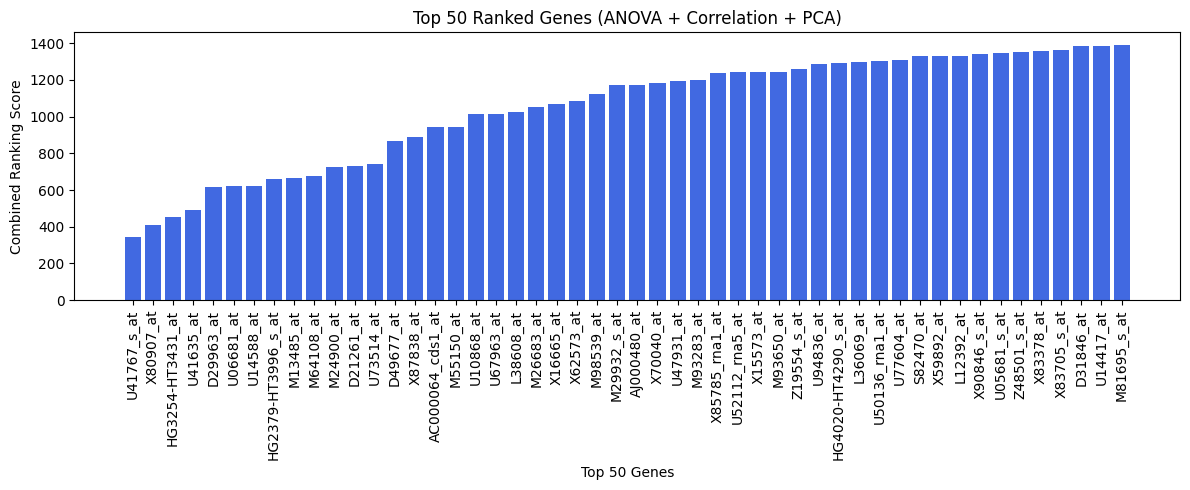

In [30]:
# Sort combined rank
combined_rank_sorted = combined_rank.sort_values()

# Extract top 40
top40_sorted = combined_rank_sorted.head(50) # change the value here for extracting more or less features based on the score

plt.figure(figsize=(12, 5))
plt.bar(top40_sorted.index, top40_sorted.values, color='royalblue')
plt.xticks(rotation=90)
plt.xlabel("Top 50 Genes")
plt.ylabel("Combined Ranking Score")
plt.title("Top 50 Ranked Genes (ANOVA + Correlation + PCA)")
plt.tight_layout()
plt.savefig("top50_features.png", dpi=300, bbox_inches='tight')
plt.show()
